In [1]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()
import PortfolioAnalyser as pa

#### Functions ####
def compute_growth_rate(dataframe, initial_value=100, initial_cost=0, ending_cost=0):
    initial_cost = initial_cost / 100
    ending_cost  = ending_cost / 100
    
    GR = ((1 + dataframe.pct_change()).cumprod()) * (initial_value * (1 - initial_cost))
    GR.iloc[0]  = initial_value * (1 - initial_cost)
    GR.iloc[-1] = GR.iloc[-1] * (1 * (1 - ending_cost))
    return GR 

def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100

def compute_return(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0, investment_value=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365.25
    
    if investment_value == 0:
        return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)
    else:
        return (dataframe.iloc[-1].div(investment_value).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)
    if freq == 'quarters':
        return dataframe.pct_change().std().mul((np.sqrt(4))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe, investment_value=0):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    if investment_value == 0:
        return(dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    else:
        return(dataframe.iloc[-1] / investment_value -1) * 100

def compute_ytd_return(dataframe):
    last_year = str(dataframe.index[-1].year)
    last_bday = pd.bdate_range(end = last_year, periods=500, freq='B')[-2]

    # slicing dataframe
    df = dataframe[last_bday:]
    return compute_return(df)

def compute_ytd_cagr(dataframe):
    last_year = str(dataframe.index[-1].year)
    last_bday = pd.bdate_range(end = last_year, periods=500, freq='B')[-2]

    # slicing dataframe
    df = dataframe[last_bday:]
    return compute_cagr(df)

def compute_ytd_StdDev(dataframe):
    last_year = str(dataframe.index[-1].year)
    last_bday = pd.bdate_range(end = last_year, periods=500, freq='B')[-2]

    # slicing dataframe
    df = dataframe[last_bday:]
    return compute_StdDev(df)

def compute_ytd_sharpe(dataframe):
    last_year = str(dataframe.index[-1].year)
    last_bday = pd.bdate_range(end = last_year, periods=500, freq='B')[-2]

    # slicing dataframe
    df = dataframe[last_bday:]
    return compute_sharpe(df)

def compute_ytd_max_DD(dataframe):
    last_year = str(dataframe.index[-1].year)
    last_bday = pd.bdate_range(end = last_year, periods=500, freq='B')[-2]

    # slicing dataframe
    df = dataframe[last_bday:]
    return compute_max_DD(df)

def compute_ytd_mar(dataframe):
    last_year = str(dataframe.index[-1].year)
    last_bday = pd.bdate_range(end = last_year, periods=500, freq='B')[-2]

    # slicing dataframe
    df = dataframe[last_bday:]
    return compute_mar(df)

def compute_performance_table(dataframe, years='si', freq='days', investment_value=0):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_cagr(dataframe, years, investment_value), compute_return(dataframe, investment_value),
                           compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'Return', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

    if years == 'ytd':
        df = pd.DataFrame([compute_ytd_cagr(dataframe), compute_ytd_return(dataframe), compute_ytd_StdDev(dataframe),
                           compute_ytd_sharpe(dataframe), compute_ytd_max_DD(dataframe), compute_ytd_mar(dataframe)])
        df.index = ['CAGR', 'Return', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = 'N/A'
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)

        # Return object
        return df

    
    else:
        df = pd.DataFrame([compute_cagr(dataframe, years, investment_value), compute_return(dataframe, investment_value),
                           compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'Return', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

In [2]:
import pandas_datareader.data as web
import datetime

**USA real GDP**
- https://fred.stlouisfed.org/series/GDPC1
    
**EU (28 GDP GROWTH rate)**
- https://fred.stlouisfed.org/series/CLVMEURSCAB1GQEU28

**CPI USA**
- https://fred.stlouisfed.org/series/CPIAUCSL

**CPI European Union**
- https://fred.stlouisfed.org/series/CP0000EU28M086NEST

**S&P 500**
- https://finance.yahoo.com/quote/%5EGSPC/

**Stoxx 600**
- https://finance.yahoo.com/quote/%5Estoxx/

**GOLD USD**
- https://www.quandl.com/data/WGC/GOLD_DAILY_USD-Gold-Prices-Daily-Currency-USD

In [3]:
us_real_gdp = web.DataReader(['GDPC1'], 'fred', start='2000')

In [4]:
eu_real_gdp = web.DataReader(['CLVMEURSCAB1GQEU28'], 'fred', start='2000')

In [5]:
cpi_usa = web.DataReader(['CPIAUCSL'], 'fred', start='2000')

In [6]:
cpi_eu = web.DataReader(['CP0000EU28M086NEST'], 'fred', start='2000')

In [7]:
import yfinance as yf
sp_500 = pd.DataFrame(yf.download("^GSPC", start="2000-01-01", end="2020-04-30")['Close'])
sp_500.columns=['S&P500']

stoxx_600 = pd.DataFrame(yf.download("^STOXX", start="2000-01-01", end="2020-04-30")['Close'])
stoxx_600.columns=['Stoxx 600']

equity = pa.merge_time_series(sp_500, stoxx_600, how='inner')

equity.columns = ['S&P 500', 'Stoxx 600']

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [8]:
import quandl

gold_usd = quandl.get("WGC/GOLD_DAILY_USD", authtoken="HU7i-qDWTo-fWcBzRZ_f")

In [9]:
### Creation of All_days Database ###
all_dates = pd.DataFrame(pd.date_range(start='2000-01-01', end='2020-05-05', freq='D'))
all_dates.set_index(all_dates[0], inplace=True)
all_dates[0] = 0
all_dates.head()

equity = all_dates.merge(equity, left_index = True, right_index = True, how='outer').fillna(method='ffill')
equity = equity.merge(gold_usd, left_index = True, right_index = True, how='outer').fillna(method='ffill')
equity = equity.drop(0, axis=1)
equity.columns =['S&P 500', 'Stoxx 600', 'Gold']

In [10]:
ISINs = ['LP06TREU', 'LBUSTRUU']
Nomes = ISINs

blb = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]

blb.columns = Nomes
blb = blb.dropna()

In [11]:
oil = web.DataReader(['WTISPLC'], 'fred', start='2000')

In [12]:
fundos = pa.merge_time_series(us_real_gdp, eu_real_gdp, how='outer')
fundos = pa.merge_time_series(fundos, cpi_usa, how='outer')
fundos = pa.merge_time_series(fundos, cpi_eu, how='outer')
fundos = pa.merge_time_series(fundos, equity, how='outer')
fundos = pa.merge_time_series(fundos, blb, how='outer')
fundos = pa.merge_time_series(fundos, oil, how='outer')
fundos = pa.normalize(fundos)
fundos.columns=['US_GDP', 'EU_GDP', 'US_CPI', 'EU_CPI', 'S&P_500', 'Stoxx_600', 'Gold', 'LP06TREU', 'LBUSTRUU', 'WTI']

In [13]:
colors = ['rgb(255, 153, 51)',    # 1 - orange
         'royalblue',            # 2 - Royalblue
         '#708090',              # 3 - Grey
         'rgb(128, 0, 128)',     # 4 - Indigo
         'rgb(219, 64, 82)',     # 5 - Red
         'rgb(0, 128, 128)',     # 6 - Teal
         '#191970',              # 7 - Navy
         'rgb(128, 128, 0)',     # 8 - Olive
         '#00BFFF',              # 9 - Water Blue
         'rgb(128, 177, 211)']   # 10 - 

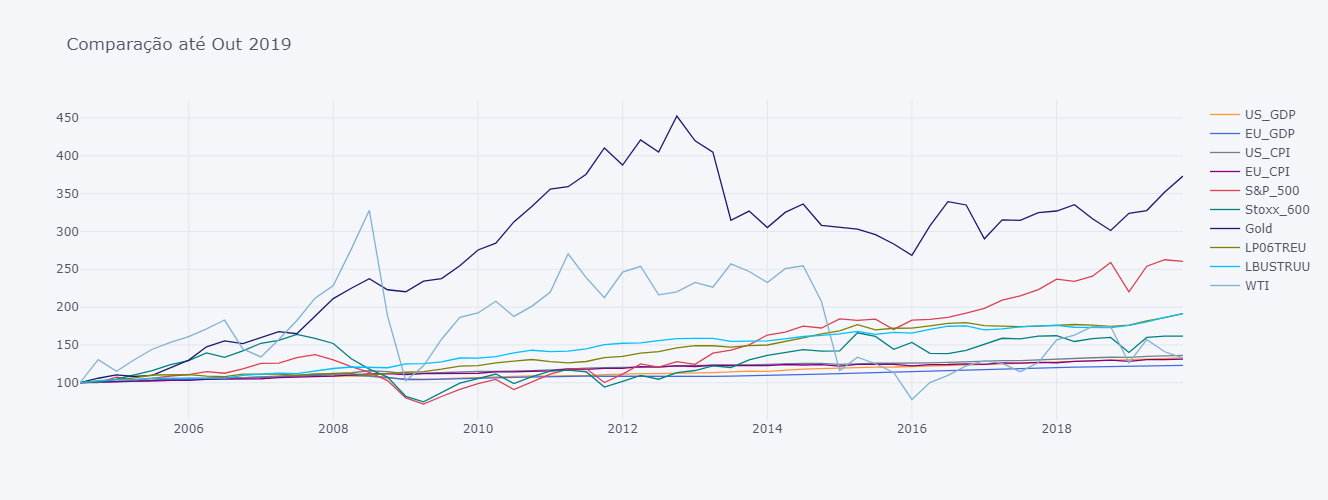

In [14]:
fundos.iplot(dimensions=pa.dimensions, colors=colors, title = 'Comparação até Out 2019')

**Nota**: Só vai até Out 2019 por causa do EU Real GDP. Não encontro dados melhores. Pordata, eurostat, The World bank etc são só anuais e muitas vezes apenas o crescimento nominal ou o per capita.

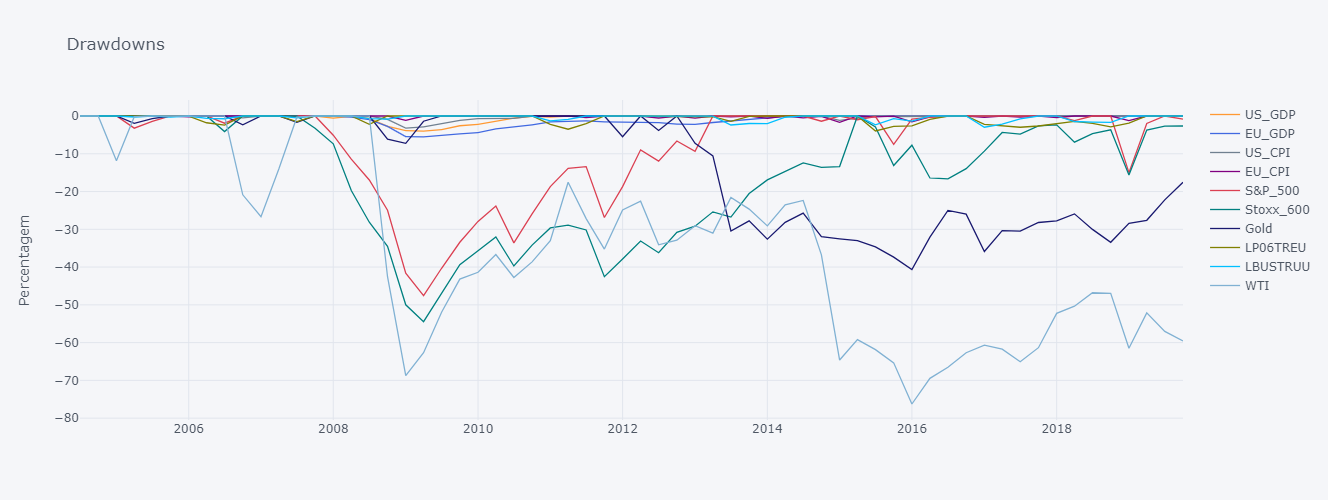

In [15]:
DD = pa.compute_drawdowns(fundos)

DD.iplot(dimensions=pa.dimensions, colors=colors, title='Drawdowns', yTitle='Percentagem')

In [16]:
pa.print_title('Performance dos fundos desde 2004')
compute_performance_table(fundos, freq='quarters')

**Performance dos fundos desde 2004**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
US_GDP,1.88%,32.89%,1.15%,1.64,-3.98%,0.47
EU_GDP,1.36%,22.90%,1.20%,1.13,-5.55%,0.25
US_CPI,2.04%,36.03%,1.37%,1.48,-3.23%,0.63
EU_CPI,1.80%,31.19%,1.75%,1.03,-1.68%,1.07
S&P_500,6.48%,160.44%,14.71%,0.44,-47.57%,0.14
Stoxx_600,3.20%,61.61%,15.74%,0.20,-54.47%,0.06
Gold,9.02%,273.21%,13.82%,0.65,-40.68%,0.22
LP06TREU,4.35%,91.44%,3.60%,1.21,-3.96%,1.10
LBUSTRUU,4.34%,91.24%,3.24%,1.34,-2.98%,1.46
WTI,1.87%,32.61%,34.11%,0.05,-76.26%,0.02


In [17]:
pa.print_title('Performance a 12 meses')
fundos_1 = pa.filter_by_date(fundos, years=1)
compute_performance_table(fundos_1, freq='quarters')

**Performance a 12 meses**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
US_GDP,2.33%,2.33%,0.56%,4.15,0.00%,inf
EU_GDP,1.23%,1.23%,0.42%,2.91,0.00%,inf
US_CPI,1.76%,1.76%,0.83%,2.11,-0.09%,19.57
EU_CPI,1.07%,1.07%,2.22%,0.48,-1.21%,0.88
S&P_500,0.53%,0.54%,21.70%,0.02,-15.01%,0.04
Stoxx_600,1.05%,1.05%,18.79%,0.06,-12.43%,0.08
Gold,23.83%,23.89%,7.20%,3.31,0.00%,inf
LP06TREU,9.77%,9.79%,2.71%,3.61,0.00%,inf
LBUSTRUU,10.57%,10.59%,2.55%,4.15,0.00%,inf
WTI,-23.69%,-23.73%,37.48%,-0.63,-27.38%,-0.87


In [18]:
pa.print_title('Performance a 3 anos')
fundos_3 = pa.filter_by_date(fundos, years=3)
compute_performance_table(fundos_3, freq='quarters')

**Performance a 3 anos**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
US_GDP,2.55%,7.84%,0.49%,5.21,0.00%,inf
EU_GDP,1.86%,5.69%,0.48%,3.92,0.00%,inf
US_CPI,2.11%,6.45%,0.72%,2.91,-0.09%,23.44
EU_CPI,1.68%,5.12%,1.79%,0.94,-1.21%,1.38
S&P_500,10.68%,35.60%,13.59%,0.79,-15.01%,0.71
Stoxx_600,4.20%,13.14%,12.00%,0.35,-13.61%,0.31
Gold,3.67%,11.41%,12.40%,0.30,-13.35%,0.27
LP06TREU,2.17%,6.66%,3.12%,0.70,-2.98%,0.73
LBUSTRUU,2.98%,9.22%,3.45%,0.86,-2.98%,1.00
WTI,2.72%,8.40%,27.65%,0.10,-27.61%,0.10


In [19]:
pa.print_title('Performance a 5 anos')
fundos_5 = pa.filter_by_date(fundos, years=5)
compute_performance_table(fundos_5, freq='quarters')

**Performance a 5 anos**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
US_GDP,2.31%,12.13%,0.48%,4.83,0.00%,inf
EU_GDP,2.01%,10.48%,0.42%,4.74,0.00%,inf
US_CPI,1.61%,8.34%,0.97%,1.67,-1.13%,1.43
EU_CPI,1.15%,5.88%,2.01%,0.57,-1.57%,0.73
S&P_500,8.60%,51.08%,11.94%,0.72,-15.01%,0.57
Stoxx_600,2.66%,14.04%,13.96%,0.19,-16.63%,0.16
Gold,3.91%,21.12%,12.82%,0.30,-14.49%,0.27
LP06TREU,3.07%,16.31%,3.88%,0.79,-3.96%,0.77
LBUSTRUU,3.31%,17.68%,3.41%,0.97,-2.98%,1.11
WTI,-8.55%,-36.07%,36.49%,-0.23,-62.46%,-0.14


In [20]:
pa.print_title('Performance a 10 anos')
fundos_10 = pa.filter_by_date(fundos, years=10)
compute_performance_table(fundos_10, freq='quarters')

**Performance a 10 anos**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
US_GDP,2.27%,25.18%,0.73%,3.11,-0.28%,8.03
EU_GDP,1.59%,17.05%,0.62%,2.58,-0.93%,1.70
US_CPI,1.74%,18.81%,0.90%,1.92,-1.16%,1.50
EU_CPI,1.54%,16.57%,1.91%,0.81,-1.68%,0.92
S&P_500,11.06%,185.50%,13.62%,0.81,-15.54%,0.71
Stoxx_600,4.98%,62.60%,13.85%,0.36,-19.23%,0.26
Gold,3.90%,46.65%,14.71%,0.27,-40.68%,0.10
LP06TREU,4.61%,56.94%,3.74%,1.23,-3.96%,1.16
LBUSTRUU,3.73%,44.19%,3.21%,1.16,-2.98%,1.25
WTI,-3.34%,-28.83%,29.87%,-0.11,-71.21%,-0.05


In [21]:
pa.print_title('Performance a 15 anos')
fundos_15 = pa.filter_by_date(fundos, years=15)
compute_performance_table(fundos_15, freq='quarters')

**Performance a 15 anos**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
US_GDP,1.85%,31.57%,1.15%,1.61,-3.98%,0.46
EU_GDP,1.36%,22.37%,1.21%,1.12,-5.55%,0.24
US_CPI,2.01%,34.82%,1.38%,1.46,-3.23%,0.62
EU_CPI,1.78%,30.29%,1.76%,1.01,-1.68%,1.06
S&P_500,6.57%,159.85%,14.82%,0.44,-47.57%,0.14
Stoxx_600,3.20%,60.43%,15.87%,0.20,-54.47%,0.06
Gold,8.76%,252.42%,13.90%,0.63,-40.68%,0.22
LP06TREU,4.27%,87.28%,3.62%,1.18,-3.96%,1.08
LBUSTRUU,4.23%,86.29%,3.24%,1.31,-2.98%,1.42
WTI,0.10%,1.56%,33.59%,0.00,-76.26%,0.00


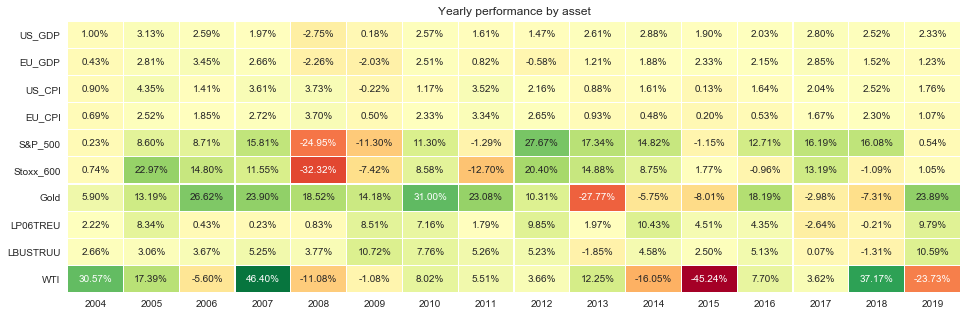

In [22]:
fundos_norm = fundos.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([yearly_quotes_fundos.iloc[:1], yearly_quotes_fundos])
yearly_quotes_fundos = pd.concat([pd.DataFrame(fundos_norm.iloc[0]).transpose(), yearly_quotes_fundos.iloc[1:]])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Calcular em valores percentuais
yearly_returns_fundos = yearly_returns_fundos / 100

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(16,5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0.02, fmt='.2%')
plt.yticks(rotation=360)
plt.title('Yearly performance by asset')
plt.show()

**Nota**: Estes dados não estão certos devido ao fim do ano não ser a 31 de Dezembro. No agreagado estão, porque está a transportar performance de um ano para o outro. Por exemplo na realidade o S&P em 2007, 2008 e 2009 teve performance de 3.53%, -38.5% e +23.45% respectivamente.

In [23]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF